# First Model

The goal here is to model an agent following a stochastic or non-stochastic dynamic within a phase space of `n_states`states.
The code should be able to :
* simulate a trajectory within the phase-space,
* calculate the occupancy distribution of each state,
* simulate multiple particle,

It should also support some basic features, such as :

* saving, loading the results of a simulation,
* run multiple simulations from an input file,
* basic plotting and handling capabilities to have a user-friendly interface.

## Imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # for plt.colorbar axes positionning
import os
import matplotlib.animation as animation
import time # to add sleeping time for test purpose

## Implementing the dynamics of the system

The dynamic of our agent is markovian : it only depends on its current state. The way it behave depends of the transition rates from a state `i` to a state `j`, and is probabilistic. The first step is to establish these rates, with a matrix.

This is the purpose of the object `DynamicalRule`. It stores :
- the number of state (`int`) : `n_states`,
- the transition matrix (`ndarray`) : `matrix`,
- WRONG the starting state (`int`) : `start_state`,
- WRONG the current date (`float`) : `date`.

The method `DynamicalRule.setMatrix` allows to **input** the desired transition matrix.


*Remark : this class could be merged with `Simulation`.*

In [2]:
class DynamicRule:
    """a class that describe the dynamic rule of a simple dicrete-state system"""
    
    def __init__(self, n_states) :
        """input : number of state the dynamic should include (size of the matrix)"""
        self.n_states = n_states
        self.matrix = np.zeros((n_states,n_states), dtype=float)
        self.start_state = 0
        self.date = 0.
        return


    def setMatrix(self, matrix) :
        if np.shape(matrix)[0] == self.n_states :
            self.matrix = matrix
        else :
            print('DynamicRule.setMatrix ERROR : input matrix of wrong size.\nMatrix left unchanged.')
        return

## Implementing an agent :

The agent will be represented by the class `Agent`.
It stores :
- a `DynamicRule` object that defines the dynamical rule this agent follows : `Agent.dynamic`,
- a state in which the agent is (`int`) : `Agent.state`,
- the list of all previous states (`list`) : `Agent.states`,
- the dates of all transitions from one state to another (`list`) : `Agent.transition_dates`.

The methods `doStep` advances the agent to the next step it will transition to, and calculate the time it will take to jump (these two values follow a precise probability).
The methods `initialize` is useless.

In [3]:
class Agent:
    """a class that simulates an agent that evolves accordingly to the markovian dynamic defined by DynamicalRule"""

    def __init__(self, n_states) :
        """input : number of states modeled by the dynamic"""
        self.dynamic = DynamicRule(n_states)
        self.state = self.dynamic.start_state
        self.states = [self.state]
        self.transition_dates = [0.0]
        return

    def initialize(self) :
        """creates the matrix of the dynamic rule
        USELESS"""
        mat = buildMatrix(self.dynamic.n_states, 'uni')
        self.dynamic.setMatrix(mat)
        return

    def doStep(self) :
        """samples the next state, then sample the time it will take to jump
        works also when some coefficient are null"""
        # creating a probability distribution from the rates
        rates = list(self.dynamic.matrix[:,self.state])
        rates.pop(self.state) # taking the lists of rate(i,i0) only when i != i0
        if np.sum(rates) == 0. : # if this state is unescapable
            self.states.append(self.state)
            self.dynamic.date += 1.
            self.transition_dates.append(self.dynamic.date)
        else :
            probs = rates/np.sum(rates)
            # calculate what will be the next state
            ind = np.argwhere(np.random.multinomial(1,probs))[0,0]
            if self.state <= ind :
                self.state = ind+1
            else :
                self.state = ind
            self.states.append(self.state)
            # calculate the time of the transition to that state
            delta = np.random.exponential(rates[ind])
            self.dynamic.date += delta
            self.transition_dates.append(self.dynamic.date)
        return

## Simulation bench

*insert description*

In [4]:
class Simulation:

    def __init__(self, n_jumps = 20, n_states = 5) :
        """data and metadata format :
        meta = [start state, number of jumps that will be simulated]
        data = [[t0=0   , t1     , t2     , ..., t_n    ],
                [state_0, state_1, state_2, ..., state_n]]
        ! Simulation.ag.dynamic.matrix is also part of the metadata !"""
        self.ag = Agent(n_states)
        self.ag.initialize()
        self.meta = np.array([0, n_jumps]) # start state and desired length of simulation (in jumps)
        self.data = np.zeros((2, n_jumps))
        return

    def run(self) :
        """runs the simulation for the indicated number of jumps"""
        n_jumps = self.meta[1]
        for i in range(n_jumps) :
            self.ag.doStep()
        self.data = np.array([self.ag.transition_dates, self.ag.states])
        return

    def plotHistogram(self, log=False) :
        """plot the histogram of occupancy in each state
        log=True for log-scale"""
        # goes through the trajectory of the system and adds the trappig time at each step to the right bin
        hist = np.zeros(self.ag.dynamic.n_states)
        current_s = int(self.data[1,0])
        for i in range(1,len(self.data[0])) :
            hist[current_s] += self.data[0,i]-self.data[0,i-1]
            current_s = int(self.data[1,i])
        # normalizing
        hist = hist/np.sum(hist)
        # handling (log) scale
        Xs = np.arange(self.ag.dynamic.n_states)
        wdth = np.zeros(self.ag.dynamic.n_states)+0.3
        if log :
            Xs += 1
            plt.xscale('log')
            plt.yscale('log')
            wdth = 0.05*Xs
        # plotting
        plt.bar(Xs, hist, width=wdth)
        plt.xlabel('state')
        plt.ylabel('relative time spent')
        # placing ticks on axes
        if self.ag.dynamic.n_states and not log <= 15 :
            plt.xticks(Xs)
        # setting an eventual log scale
        plt.show()
        return


    def plotTrajectory(self) :
        """plots the trajectory of the system over the phase space"""
        # building additionnal points (state just before each jump)
        l = len(self.data[0])
        Xs = np.zeros(2*l)
        Ys = np.zeros(2*l)
        for i in range(l-1) :
            Xs[2*i], Xs[2*i+1] = self.data[0,i], self.data[0,i+1]
            Ys[2*i], Ys[2*i+1] = self.data[1,i], self.data[1,i]
        i = l-1
        Xs[2*i], Xs[2*i+1] = self.data[0,i], self.data[0,i]*1.05
        Ys[2*i], Ys[2*i+1] = self.data[1,i], self.data[1,i]
        # plotting
        plt.plot(Xs, Ys)
        plt.xlabel('time')
        plt.ylabel('states')
        plt.text(0.9*np.amax(Xs), 0.9*np.amax(Ys), str(int(l-1)) + ' jumps')
        plt.grid(axis='y')
        plt.yticks(np.arange(self.ag.dynamic.n_states))
        plt.show()
        return

    def plotMatrix(self) :
        """plots the driving matrix of the simulation as a colormap"""
        # show matrix
        ax = plt.subplot()
        im = ax.matshow(self.ag.dynamic.matrix)
        # set colorbar (scale) next to matrix
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        # show
        plt.show()
        return

    def live(self) :
        """runs the simulation live (interactively)"""
        pass



    def saveSim(self, path) :
        """saves the data, the metadata and the matrix to the path"""
        # getting path
        if path == None :
            current = os.getcwd()
            print('Current directory : ' + current)
            path = str(input('\nEnter path+filename : '))
        # saving
        np.save(path + '_data', self.data)
        np.save(path + '_matrix', self.ag.dynamic.matrix)
        np.save(path + '_meta', self.meta)
        print('\Sim saved as :\n    ' + path.rsplit(sep='/')[-1] + '_data.npy\n    '+ path.rsplit(sep='/')[-1] + '_matrix.npy\n    ' + path.rsplit(sep='/')[-1] + '_meta.npy' )

        return

    def saveInput(self, inpt, path=None) :
        """saves only the matrix and the metadata"""
        # getting path
        if path == None :
            current = os.getcwd()
            print('Current directory : ' + current)
            path = str(input('\nEnter path+filename : '))
        # saving
        np.save(path + '_matrix', self.ag.dynamic.matrix)
        np.save(path
            + '_meta', self.meta)
        print('\Input saved as :\n    ' + path.rsplit(sep='/')[-1] + '_matrix.npy\n    ' + path.rsplit(sep='/')[-1] + '_meta.npy' )
        return

## Utilities

Some utility function that can exist outside the previous classes :
- `buildMatrix` builds transition matrix corresponding to the desired dynamic (random matrices, SSR...),
- `loadSim` returns a `Simulation` object from a set of file storing the input *and* data,
- `loadInput` returns a `Simulation` object from a set of file describing the input (matrix and metadata).

In [5]:
def buildMatrix(n_states, kind='uni', param=1.) :
    """builds a stochastic matrix, each coefficient is drawn randomly
        uni --> uniformly in [0, 1[
        mfd --> mean field (all coef. equal to param/n_states, "param" is equivalent to "J")
        bin --> binomial (1 sample)
        pow --> power-tail law (Pareto here)
        nrm --> normal law
        ssr --> ssr process (with state no <-> energy)
        BGe --> Boltzmann-Gibbs equilibrium"""
    matrix = np.zeros((n_states,n_states), dtype=float)
    if kind=='ssr' :
        for j in range(2,n_states) :
            for i in range(j) : # coefficients are non-zero only if i<j
                matrix[i,j] = 1/(j-1)
        matrix[-1,0] = 1
        matrix[0,1] = 1
    else :
        for j in range(n_states) :
            s = 0
            for i in range(n_states) :
                if   kind=='mfd' : rate = param/n_states
                elif kind=='uni' : rate = np.random.uniform()
                elif kind=='bin' : rate = np.random.binomial(1,0.5)
                elif kind=='pow' : rate = np.random.pareto(0.5)
                elif kind=='nrm' : rate = np.abs(np.random.normal()) # ! the coefficients must be postive !
                elif kind=='BGe' : rate = BG_rate(i,j)
                else :
                    print('DynamicalRule.initialize ERROR : unknown distribution\n Reminder :\n    uni --> uniformly in [0, 1[\n    bin --> binomial (1 sample)\n    pow --> power-tail law (Pareto here)\n    nrm --> normal law')
                    rate = np.random.uniform()
                matrix[i,j] = rate
                if i != j : s += rate
            matrix[j,j] = - s # s is the sum of all other transition rates : the matrix is thus stochastic
    return matrix


def loadSim(path=None) :
    """load a full simulation and returns the object"""
    # getting path
    if path == None :
        current = os.getcwd()
        print('Current directory : ' + current)
        path = str(input('\nEnter path+filename : '))
    # loading
    data = np.load(path + '_data')
    matrix = np.load(path + '_matrix')
    meta = np.load(path + '_meta')
    start_state, n_jumps = int(meta[0]), int(meta[1])
    n_states = np.shape(matrix)[0]
    sim = Simulation(n_jumps, n_states)
    sim.ag.dynamic.setMatrix(matrix)
    sim.data = data
    sim.meta = meta
    print('\Sim loaded from :\n    ' + path.rsplit(sep='/')[-1] + '_data.npy\n'  + path.rsplit(sep='/')[-1] + '_matrix.npy\n    ' + path.rsplit(sep='/')[-1] + '_meta.npy' )

    return sim

def loadInput(path=None) :
    # getting path
    if path == None :
        current = os.getcwd()
        print('Current directory : ' + current)
        path = str(input('\nEnter path+filename : '))
    # loading
    matrix = np.load(path + '_matrix')
    meta = np.load(path + '_meta')
    start_state, n_jumps = int(meta[0]), int(meta[1])
    n_states = np.shape(matrix)[0]
    sim = Simulation(n_jumps, n_states)
    sim.ag.dynamic.setMatrix(matrix)
    sim.meta = meta
    print('\Input loaded from :\n    ' + path.rsplit(sep='/')[-1] + '_matrix.npy\n    ' + path.rsplit(sep='/')[-1] + '_meta.npy' )
    return sim




## Testing utilities

In [6]:
# Test 1 : testing DynamicRule
dyn = DynamicRule(5)
dyn.setMatrix(buildMatrix(5,'uni'))
print(dyn.matrix)

[[-2.47127743  0.91413933  0.93514211  0.53935972  0.82260642]
 [ 0.24182326 -2.79975298  0.76426321  0.83213142  0.42117834]
 [ 0.58899674  0.55096225 -2.96908798  0.73231605  0.90728205]
 [ 0.74193805  0.66156191  0.58807353 -2.35758303  0.06668405]
 [ 0.89851937  0.6730895   0.68160913  0.25377584 -2.21775086]]


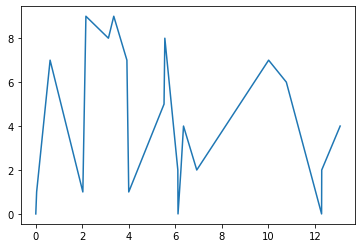

In [7]:
# Test 2 : testing Agent
ag = Agent(10)
ag.initialize()
for i in range(20) :
    ag.doStep()
plt.plot(ag.transition_dates, ag.states)

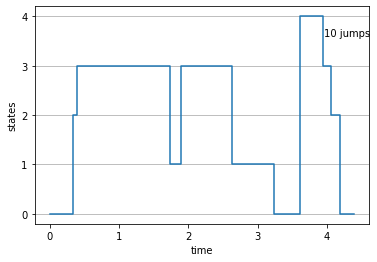

In [8]:
# Test 3 : testing Simulation.run and Simulation.plotTrajectory
sim = Simulation(10)
sim.run()
sim.plotTrajectory()

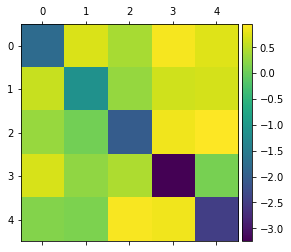

In [9]:
# Test 4 : testing Simulation.plotMatrix
sim = Simulation(10)
sim.plotMatrix()

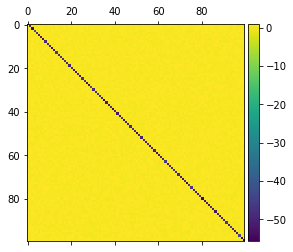

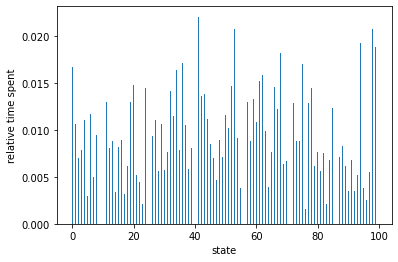

In [10]:
# Test 5 : testing Simulation.plotHistogram
sim = Simulation(n_jumps=1000, n_states=100)
sim.run()
sim.plotMatrix()
sim.plotHistogram()

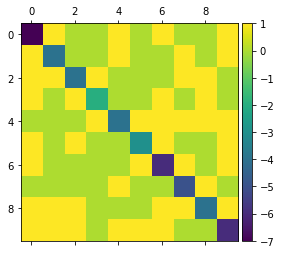

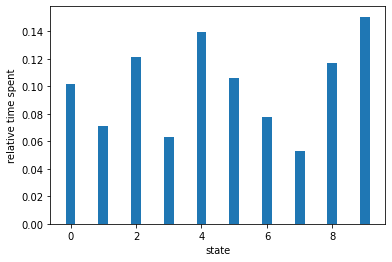

In [11]:
# Test 6 : testing re-initialization of a dyamic
sim = Simulation(n_jumps=1000, n_states=10)
mat = buildMatrix(n_states = 10, kind='bin')
sim.ag.dynamic.setMatrix(mat)
sim.run()
sim.plotMatrix()
sim.plotHistogram()

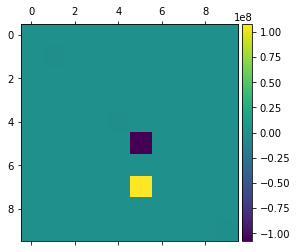

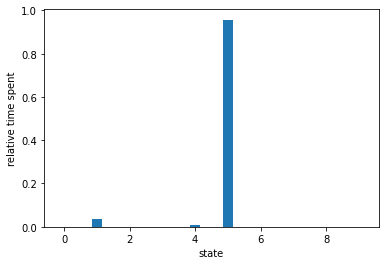

In [12]:
# Test 7 : testing different samplings of driving matrix
sim = Simulation(n_jumps=1000, n_states=10)
mat = buildMatrix(n_states = 10, kind='pow')
sim.ag.dynamic.setMatrix(mat)
sim.run()
sim.plotMatrix()
sim.plotHistogram()

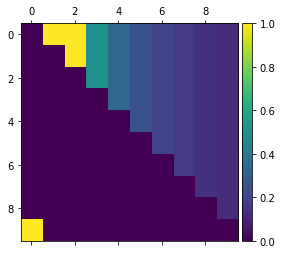

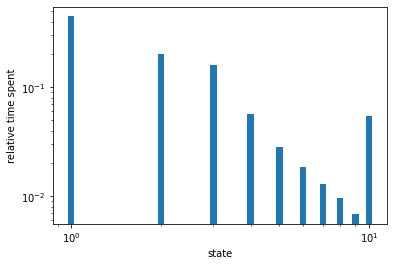

In [13]:
# Test 8 : testing SSR driving matrix and log-scale plotting
sim = Simulation(n_jumps=10000, n_states=10)
mat = buildMatrix(n_states = 10, kind='ssr')
sim.ag.dynamic.setMatrix(mat)
sim.run()
sim.plotMatrix()
sim.plotHistogram(log=True)

## Classical Bolztman-Gibbs equilibrium

Here, an agent represents **the whole system** : it is considered at equilibrium and we only consider the **macrostates**.
The transition rate from a state of energy $E$ to a state of energy $E'$ reads :
$$J(E',E) \propto \mathrm{exp}\left(-\dfrac{E'-E}{k_{B}T}\right)$$

The typical energy $k_{B}T$ will be taken as 1.
Likewise, we will map the states' index (ranging from `0` to `n_states-1` to the energy with a simple linear function `toEnergy`, without any consideration for the units at the moment :

In [14]:
def toEnergy(index) :
    return float(index+1.)

This function might be used later.

Then we can calculate the transition rate with the function `BG_rate` :

In [15]:
def BG_rate(i,j) :
    return np.exp(float(i-j)/1.2)

This rate is used with the parameter `'BGe'` in the `buiildMatrix`function.



It is important to note that here normalization is yet not important, since it is only the relative rates that will matter in `Agent.doStep`. Also, the function `buildMatrix` will insure this matrix is stochatic (the output of `BG_rate(i,i)` will be replaced).

### Simulation

Here is an attempt to simulate a Boltzmann-Gibbs equilibrium :

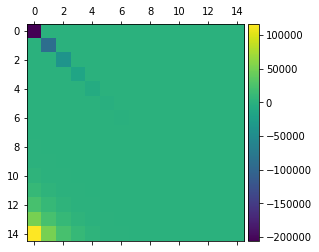

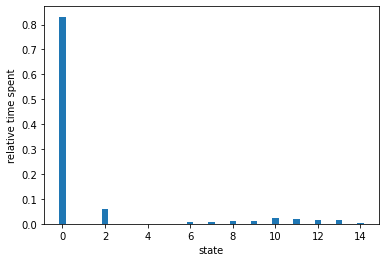

In [16]:
# Test 9 : testing Boltzman-Gibbs matrix
#
# DOESN'T WORK --> SEE STATPHYS' COURSE
#
#
n_sts=15
sim = Simulation(n_jumps=1000, n_states=n_sts)
mat = buildMatrix(n_states=n_sts, kind='BGe')
sim.ag.dynamic.setMatrix(mat)
sim.run()
sim.plotMatrix()
sim.plotHistogram(log=False)

## Bouchaud-Mézard dynamic

We now consider **out-of-equilibirum systems**, where an agent is a single particle and we consider the **microstates**.


The BM model might not be doable in a 'single state' simulation since the state will be distributed on all possible ones due to noise (e.g. the state of the system is a superposition of a finite number of states, each with ist own probability).

Ideas :
- (grain) this non-integer state becomes secable if we introduce a minimal rate for the noise. Then, for timescals sufficiently small, the description of states as a single point (and not a distribution itself) might hold,
- (space?) what is the 'shrinking sampling space' ? Is it the set of all agents (energy $\propto$ wealth) ? Is it the wealth of the wealthiest (always increasing (?)) ? Is it the people related to an agent (people only talk to people richer than them : dissipation would be buying smth from someone richer than me, driving would be trade with ppl poorer than me)...?


*Work to do : investigate last idea*

Lets first simulate a mean field model :

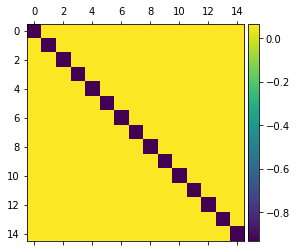

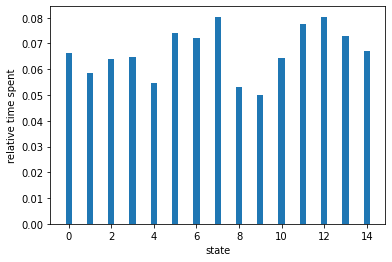

In [17]:
n_sts = 15
sim = Simulation(n_jumps=1000, n_states=n_sts)
mat = buildMatrix(n_states=n_sts, kind='mfd')
sim.ag.dynamic.setMatrix(mat)
sim.run()
sim.plotMatrix()
sim.plotHistogram()

To simulate a BM model, we will use a simple numerical resolution without using our previous classes.

In [18]:
# noise generator
def dgnl(mean=0., sigma=3, n_states=10) :
    return np.diag(np.random.normal(mean, sigma, n_states))

<IPython.core.display.Javascript object>


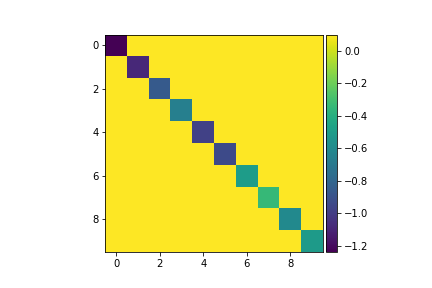

In [19]:
%matplotlib notebook
fig, ax = plt.subplots()
n_sts = 10
n_steps = 100
mn = 0.3
sgma = 0.3
mat = buildMatrix(n_states=n_sts, kind='mfd')
# ims is a list of lists, each row is a list of artists to draw in the current frame
ims = []
for i in range(n_steps):
    im = ax.imshow(mat+dgnl(mn, sgma, n_sts), animated=True)
    if i == 0:
        ax.imshow(mat)  # show an initial one first
    ims.append([im])
# set colorbar (scale) next to matrix
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
# display
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
plt.show()

<IPython.core.display.Javascript object>


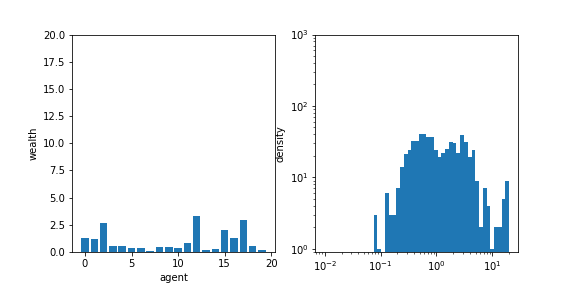

In [28]:
%matplotlib notebook
# layouts
# simulation layouts
n_sts = 20
start_state = 0
n_steps = 1000
log=True
# dynamical layouts (values from [06])
J = 3.
mu = 1.001
mn = 10
sigm = np.sqrt(J/(mu-1))
dt = 0.01*J**-1 # homgenous to a time, scaled to have a smooth evolution
# utilities
global state
global normd_state_of_first
def init_state() :
    st = np.zeros(n_sts)
    st[start_state]=1
    return st
state = init_state()
normd_state_of_first = [state[0]]
hist_bins = np.linspace(0, n_sts, 50)
if log : hist_bins = np.logspace(-2, np.log10(n_sts), 50)
tab_hist = np.histogram(normd_state_of_first, hist_bins)
Xs = np.arange(n_sts)
# adding noise to the matrix (function)
mat = buildMatrix(n_states=n_sts, kind='mfd', param=J)


# figure
fig, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize=(8.,4.))
# plotting
M = np.sum(state)/n_sts
bars1 = ax1.bar(Xs, state/M)
_, _, bars2 = ax2.hist(normd_state_of_first, hist_bins, density=True)
# axes settings
ax1.set_xlabel('agent')
ax1.set_ylabel('wealth')
ax2.set_ylabel('density')
ax1.set_ylim(0,n_sts)
if log :
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_ylim(0.9,n_steps)

# tests
#normd_state_of_first.append(10)
#normd_state_of_first.append(8)
#normd_state_of_first.append(4)
#tab_hist, _ = np.histogram(normd_state_of_first, hist_bins)
#for a, b in zip([1,2,3],[4,5,6]) :
#    print(a,b)
#for count, rect in zip(tab_hist, bars2.patches) :
#        print(count, rect)
#        rect.set_height(count)

# animation
# animate function
def animate(step) :
    global state
    global normd_state_of_first
    mtrx = mat+dgnl(mean=mn, sigma=sigm, n_states=n_sts)
    state += dt*mtrx.dot(state)
    M = np.sum(state)/n_sts
    normd_state_of_first.append(state[0]/M)
    tab_hist, _ = np.histogram(normd_state_of_first, hist_bins, density=False)
    for count, rect in zip(tab_hist, bars2.patches) :
        rect.set_height(count)
    for i in range(n_sts) :
        bars1[i].set_height(state[i]/M)
    if step%n_steps==0 :
        state = init_state()
        normd_state_of_first = [state[0]]
    return bars1.patches+bars2.patches
# run
ani = animation.FuncAnimation(fig, animate, interval=20, blit=True)
plt.show()

## Sample-Space Reducing dynamic (SSR)

A classical SSR system (which can be found in [05]) is defined by particular transition rates :
$$ J(i,j) = \left\lbrace \begin{array}{ll} 0 \text{ if } i >= j \\ \frac{1}{j-1} \text{ if } i < j \\ 1 \text{ if } i=N \text{ and } j=0 \end{array} \right.$$

The transition matrix for such a system looks like the following :

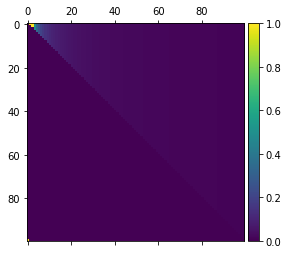

In [21]:
%matplotlib inline
nj=10000
ns=100
sim = Simulation(n_jumps=nj, n_states=ns)
mat = buildMatrix(n_states=ns, kind='ssr')
sim.ag.dynamic.setMatrix(mat)
sim.plotMatrix()

The distribution obtained with this process is a power-law :

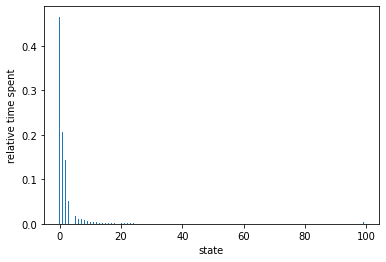

In [22]:
sim.run()
sim.plotHistogram()

... or in log-scale :

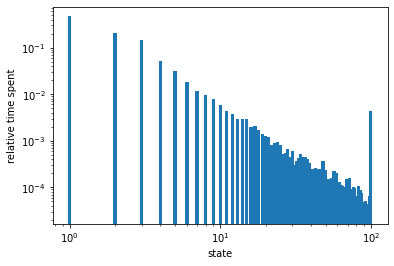

In [23]:
sim.plotHistogram(log=True)

In [24]:
a = [2,3]
a.extend([3,4])
print(a)

[2, 3, 3, 4]


<IPython.core.display.Javascript object>


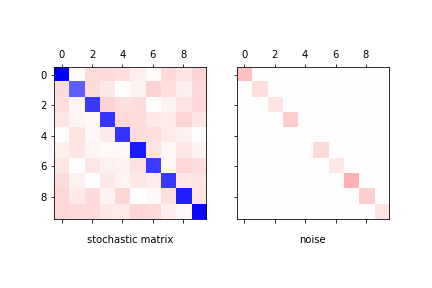

In [45]:
# codelines to generate an image (usefull in weight_dynamic.ipynb)

%matplotlib notebook
import matplotlib.colors as colors

def genNoise(dim=5, rule='BMs', inpt=(1.,10.)) :
    """generates a random matrix of shape (dim, dim) according to a certain rule ('rule')
    kwarg 'inpt' is a tuple that can contain some necessary parameters (ex. for a gaussian noise : mean and variance)
    uni --> uniformly in [0, 1[
    bin --> binomial (1 sample)
    pow --> power-tail law (Pareto here)
    nrm --> normal law. INPUT : (mean,scale)=inpt
    BMs --> normal law. INPUT : as 'nrm' but scale=np.sqrt(2)*inpt[1]"""
    if rule=='nrm' :
        mean, sigm = inpt
        matrix = np.diag(np.random.normal(loc=mean, scale=sigm, size=dim))
    elif rule=='BMs' :
        mean, sigm = inpt
        matrix = np.diag(np.random.normal(loc=mean, scale=np.sqrt(2)*sigm, size=dim))
    elif rule=='uni' :
        matrix = np.diag(np.random.uniform(size=dim))
    elif rule=='bin' :
        matrix = np.diag(np.random.binomial(n=1, size=dim))
    elif rule=='pow' :
        matrix = np.diag(np.random.pareto(size=dim))
    elif False :
        print('Impossible !')
    else :
        print('ERROR - genNoise() - unknown noise rule, normal law used instead (mean=1., scale=10.)\nReminder :\n    uni --> uniformly in [0, 1[\n    bin --> binomial (1 sample)\n    pow --> power-tail law (Pareto here)\n    nrm --> normal law (scale=inpt[1]\n    BMs --> normal law where scale=np.sqrt(2)*inpt[1]')
        mean, sigm = 1.,10.
        matrix = np.diag(np.random.normal(loc=mean, scale=sigm, size=dim))
    return matrix

sim = Simulation(n_states=10)
mat = sim.ag.dynamic.matrix

noise = genNoise(dim=10, inpt=(1., .5))

norm1 = colors.CenteredNorm(vcenter=0, )

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
# show matrix
im1 = ax1.matshow(mat, cmap='bwr', norm=norm1)
ax1.set_xlabel('\nstochastic matrix')
im2 = ax2.matshow(noise, cmap='bwr', norm=norm1)
ax2.set_xlabel('\nnoise')
# set colorbar (scale) next to matrix
# show
plt.show()